In [96]:
%matplotlib inline
from ecell4 import *
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy import special
from scipy.optimize import curve_fit

rm = 0.005  
D = 1
kd= 4.0*math.pi*D*2*rm
r0=0.256318
f=1.0208582
print('tm',(2*rm*f)**2/(6*D))
oldL= 350*rm

def getkt2(st,t,Vr): #two-point
    ks = -Vr *(st[2:]-st[:-2])/st[:-2]/(t[2:]-t[:-2])/N
    return ks

def getkt5(st,t,Vr): #five-point
    s1=st[0:-5]
    s2=st[1:-4]
    s4=st[3:-2]
    s5=st[4:-1]
    ks2= (-Vr*(-s5+8*s4-8*s2+s1)/s1/N/12./t[1]-t[0])
    return ks2

def getktexp(st,t,Vr):
    ks = np.array([-math.log(d)*Vr/tt/N for d,tt in zip(st[2:]/st[:-2],(t[2:]-t[:-2]))])
    return ks

def Phi(xx):
    return special.erfcx(xx)
    #return 1./( (377.*xx/324)+(1+ (314.*(xx**2)/847) )**0.5)

def getktt(ka,kdd,rm,tc):
    tau = ((ka*2*rm/(ka+kdd))**2)/(D)
    kt1 = np.array([(ka*kdd/(ka+kdd))*(1+(ka/kdd)*Phi(ka*(t/tau)**0.5 /kdd)) for t in tc])
    return kt1


def plotk(dat,k_factor,voxelr,lag,yl,m,ts,N,L):    
    if m=='o': mark='ori'
    else: mark = 'corrected'        
    w = spatiocyte.SpatiocyteWorld(ones()*L,voxelr)
    l1,l2,l3 = tuple(w.actual_lengths())
    Vact=l1*l2*l3
    print('Vac',Vact,'V',L**3)        
    print('kfactor='+str(k_factor))
    ka = k_factor*kd
    kon = (ka*kd)/(ka+kd)
    Prxn = ka/(3*2**0.5*D*2*voxelr)      
    print('P',Prxn)
    def simplekt(t,A,B):
        return A*(1+B/np.sqrt(t))
        
    def simplekt2(t,Prxn):
        #Prxn = ka/(3*2**0.5*D*2*voxelr)  
        v = voxelr
        #v=4*math.pi*rm*2/C/(1./r0 -1)
        alpha = 1+Prxn/(1./r0 -1)        
        return (3*2**0.5*v*Prxn/alpha)*(1+(1-1./alpha)*v/(math.pi*t)**0.5)    
    def simplekt3(t,v):
        Prxn = ka/(3*2**0.5*D*2*voxelr)  
        if Prxn>1:
            Prxn=1
        #v=4*math.pi*rm*2/C/(1./r0 -1)
        alpha = 1+Prxn/(1./r0 -1)        
        return (3*2**0.5*v*Prxn/alpha)*(1+(1-1./alpha)*v/(math.pi*t)**0.5)
    def simplekt1(t,C):
        #return kon*(1+(ka*C/(kd+ka))*(math.pi*D*t)**0.5)    
        return kon*(1+(ka*C/(kd+ka))/(math.pi*D*t)**0.5)    
    aeff = k_factor*rm*2/(1+k_factor)
    cb = N/Vact
    kss = 4*math.pi*D*aeff*(1+(4*math.pi*aeff**3*cb)**0.5)
    tm =(2*voxelr)**2/(6*D)
    w = spatiocyte.SpatiocyteWorld(ones()*L,voxelr)
    Vr = w.calculate_volume(ones()*L,voxelr)
    Pacc= ka/3/2**0.5/D/2/voxelr
    kdd = 3*(2**0.5)*D*2*voxelr*(1/r0 -1)
    kefftheory = kdd*Pacc/(Pacc+1/r0 -1)
    tau = ((ka*2*rm/(ka+kd))**2)/(D)
    
    tc=dat[:,0][::lag]
    tc=np.insert(tc,0,0)
    mnac=dat[:,1][::lag]
    mnac=np.insert(mnac,0,N)
    #intkt = [kon*(t+tau*((kd/ka)*(Phi(ka*((t/tau)**(0.5))/kd)-1)+2*(math.sqrt(t/np.pi/tau)))) for t in tc]
    #st = np.array([math.exp(-ik*N/Vr) for ik in intkt])
    stsim = (mnac/mnac[0])        
    dst = (np.log(stsim[1:])-np.log(stsim[:-1]))/(N/Vact) #k(t)=dlnS(t)/dt/cb 
    dtc = tc[1:]-tc[:-1]
    tk = tc[:-1]
    inx=tk>ts
    ks=np.array([-s/t for t,s in zip(dtc,dst)]    )

    #weight = (mnac[0]-mnac)[1:-1]
    #weight = 1./(stsim[1:-1][inx])
    popt,pcov = curve_fit(simplekt,tk[inx],ks[inx])#,sigma=weight,absolute_sigma=False)
    perr = np.sqrt(np.diag(pcov))
    print('fit result',popt)#,popt[0]/(3*2**0.5))
    #ref = popt[0]/f
    #print('effective r',ref,'diff to rm',(rm-ref*0.5)*100/rm)
    konfit = popt[0]
    #Co = konfit*(1+1./k_factor)/D/2/voxelr/(1./r0-1)
    #kap = Co*ka/3/2**0.5
    #kdp=Co*D*2*voxelr*(1./r0-1)
    #print('kap,ka',kap,ka)
    #print('kdp,kd',kdp,kd)
    #kafit=1./(1./konfit-1./kd)
    #print('kafit={:.5} and ka={:.5}'.format(kafit,ka))
    #print('cov matrix',pcov)
    #kt1 = getktt(ka,kdd,rm,tk) #Spatheory
    tmax=0.05
    tt=np.arange(tk[0],tmax,tk[1])
    #rmp = 3*2**0.5*(1./r0-1)*popt[0]/4/math.pi/2
    #kap = popt[0]*ka/(2*voxelr)  
    #kdp = 3*2**0.5*D*popt[0]*(1./r0-1)
    #print('ka{},kd{},rm{}'.format(ka,kd,rm))
    #print('kap={},kdp={},rmp={}'.format(kap,kdp,rmp))
    cc=0.9558
    #kt2 = getktt(ka*cc,kd*cc,rm*f,tt)#using rv fit
    kt3 = getktt(ka,kd,rm,tt)#ori CK
    #kt4 = getktt(ka,kdd,voxelr,tt)#using kafit   
    #print('ka,ks,kt0',ka,ks[0],kt2[0])    
    #print('ka={},ks0={},kt10={}'.format(ka,ks[0],kt1[0]))
    error = lambda x,y: (x-y)*100/x
    print('kon={:.6},konfitted={:.6},error={:.6}%'.format(kon,konfit,error(kon,konfit)))
    #fig,(ax1,ax2)=plt.subplots(2,1,figsize=(6,8))
    
    ax1.plot(tk,ks/kon,'g.',label='Sim '+mark+' $k_a/k_D=$'+str(k_factor),markersize=5)
    tkm = np.arange(tk[inx][0],tmax,1e-4)
    ktfit = simplekt(tt,*popt)
    print('rmse',np.sqrt(np.sum(simplekt(tk[inx],*popt)-ks[inx])**2))
    ax1.plot(tt,simplekt(tt,*popt)/kon,'b-',label='fitted result',linewidth=1.5)
    lw=1.
    #ax1.semilogx(tt,ktfit/kon,'r-',label='fitted with k(t)',linewidth=lw)
    #ax1.plot(tt,kt2,'b-',label='corrected',linewidth=lw)
    ax1.semilogx(tt,kt3/kon,'r-',label='CK k(t)',linewidth=lw)
    #ax1.plot(tt,kt4/kon,'c-',label='lattice',linewidth=lw)
    #ax1.plot(tk,kt2,'-',label='CK theory',linewidth=2)
    #print('kas',ka,ks[0],kafit)
    meanks = np.mean(ks[inx])
    #print('diff btwn fitted and CK={:.5}%'.format(error(kt2[-1],ktfit[-1])))
    #print('diff btwn fitted and kt with fitted ka,kd={:.5}%'.format(error(ktfit[-1],kt4[-1])))
    #print('diff btwn kt with fitted ka and fitted={:.5}%'.format(error(ktfit[-1],kt3[-1])))
    print(' ')
    #ax1.set_ylim(0.1,0.2)
    #ax1.set_ylim(min(ks),max(ks))
    #ax1.plot(tc,[1]*len(tc),'r-')
    #if len(yl)!=0:
    #    ax1.set_ylim([yl[0],yl[1]])    
    #plt.semilogy(tc[inx],[np.exp(fit[0]*t) for t in tc[inx]],'r-',label='fiting')
    #plt.ylim(0,1)
    #ax2.plot(tc,stsim,'.',label='sim $k_a/k_D=$'+str(k_factor))
    ax1.legend(loc='best')
    #ax1.set_xlim(1e-5,1e-2)
    ax1.set_ylim(1.,2)
    ax1.set_ylabel('k(t)/kon')
    #ax2.set_ylabel('Survival probability of A')
    #ax2.set_xlabel('time')
    fig.set_size_inches(12, 8)   
    print('ka',ka,ks[:2])
    #plt.savefig("figure/survival_probability_ori_correct_theory.png",format='png',dpi=300)            

tm 1.7369191075120664e-05


Vac 1.0462752424660025 V 1
kfactor=100
P 290.14038960281107
fit result [ 0.12348701  0.00564944]
kon=0.12442,konfitted=0.123487,error=0.749483%
rmse 1.04246833388e-10
 
ka 12.566370614359174 [ 0.7688764  0.2419531]


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in true_divide


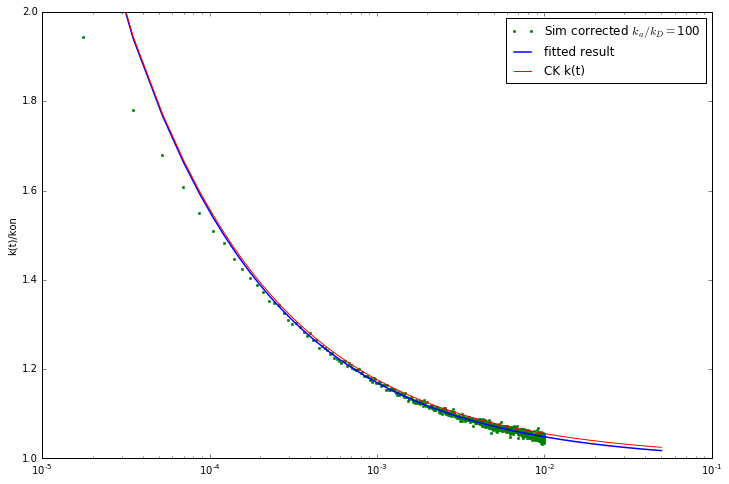

In [97]:
#kasim is slightly larger than ka.
start=2e-4
ds = 1
fig,ax1 = plt.subplots()
dat = np.loadtxt('/home/chew/outputdata/kfacc100a1meanNa50000L1tmdur001',delimiter=',')
plotk(dat,100,f*rm,ds,[1,2.1],'c',start,1000,1)
#dat = np.loadtxt('/home/chew/outputdata/kfacc100a1meanNa29998L1dur005',delimiter=',')
#plotk(dat,100,f*rm,15,[1,1.4],'c',start,1000,1.)

In [84]:
Afitted=0.12384759 
Bfitted= 0.00540937
rm = 0.005  
D = 1
f=1.0208582
kD= 4.0*math.pi*D*2*rm
r0=0.256318
f=1.0208582
ka = 100*kd
Prxn = ka/(3*2**0.5*D*2*f*rm)  
kon = (ka*kd)/(ka+kd)
konl = 3*2**0.5*D*f*2*rm*(1./r0-1)*Prxn/(Prxn+(1./r0-1))
C = 0.413497
aeff = ka * (2*rm) / (ka + kD) * 4*math.pi*C/(3*math.sqrt(3))
B = aeff / math.sqrt(D) / math.sqrt(math.pi)
er=lambda x,y: (abs(x-y)*100/x)
Bck=ka * (2*rm) / (ka + kD)/math.sqrt(D) / math.sqrt(math.pi)
print(er(kon,Afitted),er(B,Bfitted),er(Bck,Bfitted),er(Bck,B))
print(er(Afitted,konl))                                         
kasim=12.67914196
print(ka,kasim)
print(er(ka,kasim))
keffl=kasim/(1+Prxn*(0.34466))
print(er(Afitted,keffl))

0.4596715004821707 3.1627041728082257 3.162627256525022 7.942836749657381e-05
0.4617883757907656
12.566370614359174 12.67914196
0.8974058548931106
1.3635583477511255


Vac 1.0462752424660025 V 1
kfactor=100
P 290.14038960281107
fit result [ 0.12648351  0.00523202]
kon=0.12442,konfitted=0.126484,error=-1.6589%
rmse 4.81276671849e-08
 
ka 12.566370614359174 [ 12.67914196  11.37744426]


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in true_divide


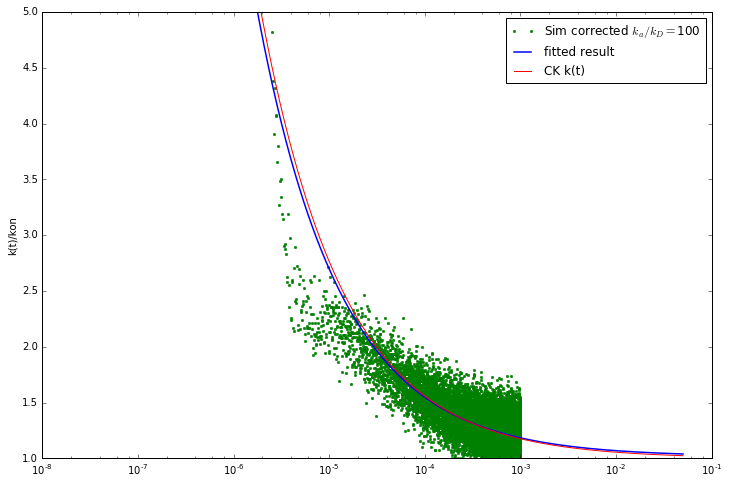

In [95]:
#kasim is slightly larger than ka.
start=1e-4
ds = 1
fig,ax1 = plt.subplots()
dat = np.loadtxt('/home/chew/outputdata/kfacc100a1meanNa10000shortdur',delimiter=',')
plotk(dat,100,f*rm,ds,[1,2.1],'c',start,1000,1)
#dat = np.loadtxt('/home/chew/outputdata/kfacc100a1meanNa29998L1dur005',delimiter=',')
#plotk(dat,100,f*rm,15,[1,1.4],'c',start,1000,1.)

(167043, 2)
Vac 1.0462752424660025 V 1
kfactor=100
P 290.14038960281107
fit result [ 0.12347577  0.00566704]
kon=0.12442,konfitted=0.123476,error=0.758518%
rmse 8.51699188953e-09
 


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in true_divide


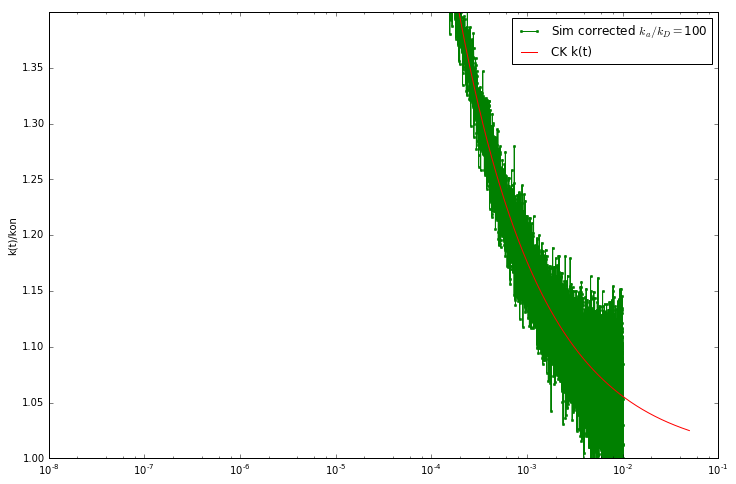

In [59]:
#kasim is slightly larger than ka.
start=1e-4
ds = 10
fig,ax1 = plt.subplots()
dat = np.loadtxt('/home/chew/outputdata/kfacc100a1meanNa49999L1dur001',delimiter=',')
print(dat.shape)
plotk(dat,100,f*rm,ds,[1,2.1],'c',start,1000,1)
#dat = np.loadtxt('/home/chew/outputdata/kfacc100a1meanNa20000L5simdtdur001',delimiter=',')
#plotk(dat,100,f*rm,ds,[1,2.1],'c',start,1000,5)
#print(dat.shape)

Vac 1.0462752424660025 V 1
kfactor=100
P 290.14038960281107
fit result [ 0.12493059  0.00470541]
kon=0.12442,konfitted=0.124931,error=-0.41077%
rmse 1.11501918809e-11
 


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in true_divide


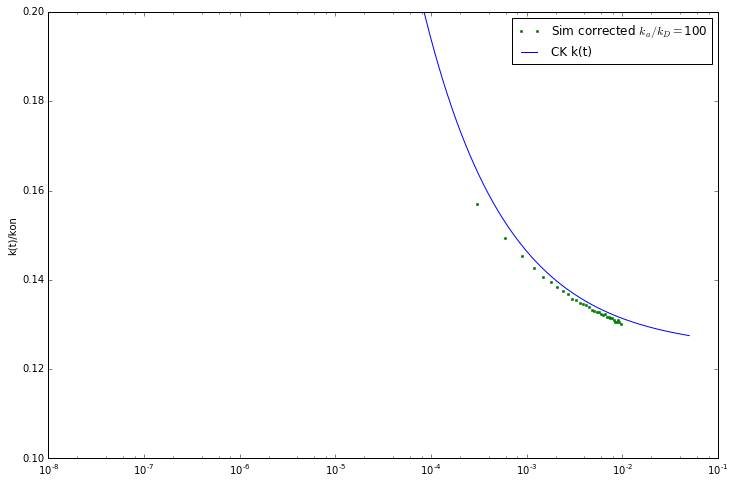

In [227]:
#kasim is slightly larger than ka.
start=1e-4
ds = 5000
fig,ax1 = plt.subplots()
dat = np.loadtxt('/home/chew/outputdata/kfacc100a1meanNa49999L1dur001',delimiter=',')
plotk(dat,100,f*rm,ds,[1,2.1],'c',start,1000,1)
#dat = np.loadtxt('/home/chew/outputdata/kfacc100a1meanNa29998L1dur005',delimiter=',')
#plotk(dat,100,f*rm,15,[1,1.4],'c',start,1000,1.)

In [151]:
%matplotlib inline
from ecell4 import *
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy import special
from scipy.optimize import curve_fit

rm = 0.005  
D = 1
kd= 4.0*math.pi*D*2*rm
r0=0.256318
f=1.0208582
print('tm',(2*rm*f)**2/(6*D))
oldL= 350*rm

def getkt2(st,t,Vr): #two-point
    ks = -Vr *(st[2:]-st[:-2])/st[:-2]/(t[2:]-t[:-2])/N
    return ks

def getkt5(st,t,Vr): #five-point
    s1=st[0:-5]
    s2=st[1:-4]
    s4=st[3:-2]
    s5=st[4:-1]
    ks2= (-Vr*(-s5+8*s4-8*s2+s1)/s1/N/12./t[1]-t[0])
    return ks2

def getktexp(st,t,Vr):
    ks = np.array([-math.log(d)*Vr/tt/N for d,tt in zip(st[2:]/st[:-2],(t[2:]-t[:-2]))])
    return ks

def Phi(xx):
    return special.erfcx(xx)
    #return 1./( (377.*xx/324)+(1+ (314.*(xx**2)/847) )**0.5)

def getktt(ka,kdd,rm,tc):
    tau = ((ka*2*rm/(ka+kdd))**2)/(D)
    kt1 = np.array([(ka*kdd/(ka+kdd))*(1+(ka/kdd)*Phi(ka*(t/tau)**0.5 /kdd)) for t in tc])
    return kt1


def plotk(dat,k_factor,voxelr,lag,yl,m,ts,N,L):    
    if m=='o': mark='ori'
    else: mark = 'corrected'        
    w = spatiocyte.SpatiocyteWorld(ones()*L,voxelr)
    l1,l2,l3 = tuple(w.actual_lengths())
    Vact=l1*l2*l3
    print('Vac',Vact,'V',L**3)        
    print('kfactor='+str(k_factor))
    ka = k_factor*kd
    kon = (ka*kd)/(ka+kd)
    Prxn = ka/(3*2**0.5*D*2*voxelr)      
    print('P',Prxn)
    def simplekt(t,A,B):
        return A*(1+B/np.sqrt(t))
        
    def simplekt2(t,Prxn):
        #Prxn = ka/(3*2**0.5*D*2*voxelr)  
        v = voxelr
        #v=4*math.pi*rm*2/C/(1./r0 -1)
        alpha = 1+Prxn/(1./r0 -1)        
        return (3*2**0.5*v*Prxn/alpha)*(1+(1-1./alpha)*v/(math.pi*t)**0.5)    
    def simplekt3(t,v):
        Prxn = ka/(3*2**0.5*D*2*voxelr)  
        if Prxn>1:
            Prxn=1
        #v=4*math.pi*rm*2/C/(1./r0 -1)
        alpha = 1+Prxn/(1./r0 -1)        
        return (3*2**0.5*v*Prxn/alpha)*(1+(1-1./alpha)*v/(math.pi*t)**0.5)
    def simplekt1(t,C):
        #return kon*(1+(ka*C/(kd+ka))*(math.pi*D*t)**0.5)    
        return kon*(1+(ka*C/(kd+ka))/(math.pi*D*t)**0.5)    
    aeff = k_factor*rm*2/(1+k_factor)
    cb = N/Vact
    kss = 4*math.pi*D*aeff*(1+(4*math.pi*aeff**3*cb)**0.5)
    tm =(2*voxelr)**2/(6*D)
    w = spatiocyte.SpatiocyteWorld(ones()*L,voxelr)
    Vr = w.calculate_volume(ones()*L,voxelr)
    Pacc= ka/3/2**0.5/D/2/voxelr
    kdd = 3*(2**0.5)*D*2*voxelr*(1/r0 -1)
    kefftheory = kdd*Pacc/(Pacc+1/r0 -1)
    tau = ((ka*2*rm/(ka+kd))**2)/(D)
    tc=dat[:,0][::lag]
    tc=np.insert(tc,0,0)
    mnac=dat[:,1][::lag]
    mnac=np.insert(mnac,0,N)
    C = ka/kd/tau**0.5
    intkt = [kon*(t-ka*(1-2*C*(t/math.pi)**0.5-Phi(C*t**0.5))/kd/C**2) for t in tc]
    st = np.array([math.exp(-ik*N/Vr) for ik in intkt])
    stsim = (mnac/mnac[0])      
    stm = stsim[(tc>tm)][0]
    stmt = st[(tc>tm)][0]
    print('S(tm)=',stm,stmt)
    print('sim,theory',stsim[:3],st[:3])
    print(stsim[-2:],st[-2:])
    tmax=0.05
    ax1.plot(np.logspace(-8,-4,100),[stm]*100)
    ax1.plot(np.logspace(-8,-4,100),[stmt]*100)
    ax1.plot(len(np.logspace(-1,0,100))*[tm],np.logspace(-1,0,100),'-')    
    ax1.plot(tc,stsim,'g-',label='Sim '+mark+' $k_a/k_D=$'+str(k_factor),markersize=5)
    ax1.loglog(tc,st,'r-',label='theory',linewidth=1.5)
    lw=1.

    ax1.legend(loc='best')
    #ax1.set_xlim(tm,0.1)
    ax1.set_ylim(0.9,1.05)
    ax1.set_ylabel('S(t)')
    #ax2.set_ylabel('Survival probability of A')
    #ax2.set_xlabel('time')
    fig.set_size_inches(10, 6)   
    #plt.savefig("figure/survival_probability_ori_correct_theory.png",format='png',dpi=300)            

tm 1.7369191075120664e-05


Vac 1.0462752424660025 V 1
kfactor=100
P 290.14038960281107
S(tm)= 0.9872396 0.992526388462
sim,theory [ 1.         0.9992748  0.9986245] [ 1.          0.9997596   0.99962458]
[ 0.8470718  0.8470659] [ 0.85146104  0.85145391]


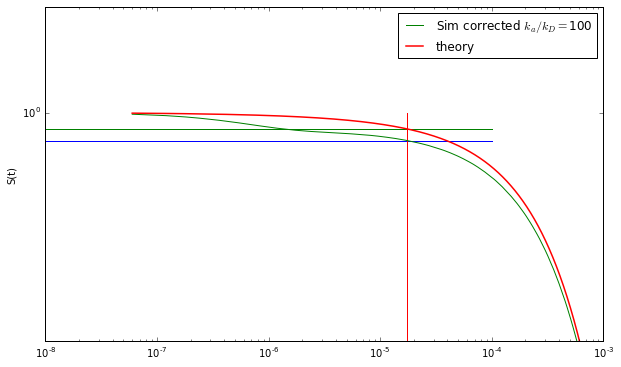

In [152]:
#kasim is slightly larger than ka.
start=1e-4
ds = 1
fig,ax1 = plt.subplots()
dat = np.loadtxt('/home/chew/outputdata/kfacc100a1meanNa10000shortdur',delimiter=',')
plotk(dat,100,f*rm,ds,[1,2.1],'c',start,1000,1)
#dat = np.loadtxt('/home/chew/outputdata/kfacc100a1meanNa29998L1dur005',delimiter=',')
#plotk(dat,100,f*rm,15,[1,1.4],'c',start,1000,1.)

Vac 1.0462752424660025 V 1.0
kfactor=100
P 290.14038960281107
sim,theory [ 1.          0.98723228  0.98325898  0.97963071  0.97622602] [ 1.          0.99252639  0.98821418  0.98444399  0.98095848]
[ 0.00188973  0.00188569  0.00188189  0.00187829  0.00187426] [ 0.0019637   0.00195955  0.00195541  0.00195128  0.00194714]


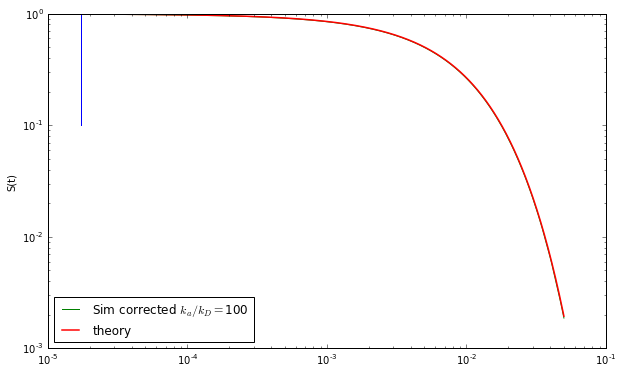

In [96]:
start=0.01
ds = 1
fig,ax1 = plt.subplots()
dat = np.loadtxt('/home/chew/outputdata/kfacc100a1meanNa29998L1dur005',delimiter=',')
plotk(dat,100,f*rm,ds,[0.12,0.14],'c',start,1000,1.)